In [4]:
import torch 
import torchvision
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import fastai.vision.all

# `1`. 크롤링을 통한 이미지 분석 및 CAM -- 30점

`(1)` 두 가지 키워드로 크롤링을 수행하여 이미지자료를 모아라. (키워드는 각자 마음에 드는 것으로 설정할 것) -- 01wk-1 의 HW를 그대로 활용해도 무방

`(2)` ImageDataLoaders.from_folder 를 이용하여 dls를 만들어라. 

`(3)` resnet34를 이용하여 학습하라. 

`(4)` CAM (class activation mapping)을 이용하여 (3)의 모형의 판단근거를 시각화하라. 

# `2`. 생성모형 / GAN -- 40점

아래는 `torchvision`을 활용하여 MNIST 데이터를 불러오고 `DataLoader`를 생성하는 코드이다. 

In [8]:
# Data preprocessing
ds = dataset = torchvision.datasets.MNIST(
    root = './data',
    download=True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(64), # 이미지를 (64,64)로 resize 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)
# Dataloader
dl = torch.utils.data.DataLoader(
    ds, 
    batch_size=120,
    shuffle=True, 
)

`(1)` `iter`와 `next`를 이용하여 데이터로더의 첫번째 배치를 출력하라. 하나의 배치에 몇개의 이미지가 있는가? 이미지는 흑백인가 칼라인가? 이미지의 크기는 얼마인가? 

(풀이) 

In [9]:
xi_real, _  = next(iter(dl))

In [10]:
xi_real.shape

torch.Size([120, 1, 64, 64])

`(2)` 아래의 함수를 이용하여 하나의 배치에 포함된 이미지를 출력하라. 

In [14]:
def imshow(xi_real):
    plt.imshow(torch.einsum('cij->ijc',torchvision.utils.make_grid(xi_real, padding=2, normalize=True)))

(풀이)

In [15]:
xi_real, _ = next(iter(dl))

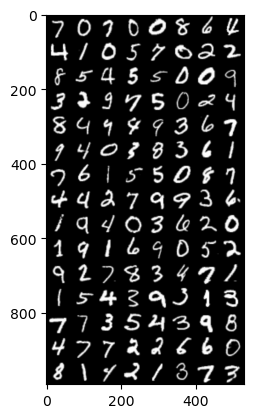

In [16]:
imshow(xi_real)

`(3)` 아래의 코드를 이용하여 `net_police`를 생성하라. 

In [17]:
net_police = torch.nn.Sequential(
    # Layer1
    torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.LeakyReLU(0.2),
    # Layer2
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    # Layer3
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    # Layer4
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    # Layer5
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)

`net_police`에 하나의 배치를 넣어보고 각 층별 출력크기를 조사하라. 

(풀이)

In [18]:
xi_real, _ = next(iter(dl))

In [19]:
print(f'xi_real -- {xi_real.shape}')
print(f'Layer1 -- {net_police[:2](xi_real).shape}')
print(f'Layer2 -- {net_police[:5](xi_real).shape}')
print(f'Layer3 -- {net_police[:8](xi_real).shape}')
print(f'Layer4 -- {net_police[:11](xi_real).shape}')
print(f'Layer5 -- {net_police(xi_real).shape}')

xi_real -- torch.Size([120, 1, 64, 64])
Layer1 -- torch.Size([120, 64, 32, 32])
Layer2 -- torch.Size([120, 128, 16, 16])
Layer3 -- torch.Size([120, 256, 8, 8])
Layer4 -- torch.Size([120, 512, 4, 4])
Layer5 -- torch.Size([120, 1])


`(4)` 아래의 코드를 이용하여 `net_faker`를 생성하라. 

In [20]:
net_faker = torch.nn.Sequential(
    # Layer1
    torch.nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    # Layer2
    torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    # Layer3
    torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    # Layer4
    torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    # Layer5
    torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh()
)

`net_faker`에 아래의 noise를 넣어보고 각 층별 출력크기를 조사하라. 

```Python
ni = torch.randn(batch_size, 100, 1, 1)
```

(풀이)

In [21]:
ni = torch.randn(120, 100, 1, 1)

In [22]:
print(f'ni -- {ni.shape}')
print(f'Layer1 -- {net_faker[:3](ni).shape}')
print(f'Layer2 -- {net_faker[:6](ni).shape}')
print(f'Layer3 -- {net_faker[:9](ni).shape}')
print(f'Layer4 -- {net_faker[:12](ni).shape}')
print(f'Layer5 -- {net_faker(ni).shape}')

ni -- torch.Size([120, 100, 1, 1])
Layer1 -- torch.Size([120, 512, 4, 4])
Layer2 -- torch.Size([120, 256, 8, 8])
Layer3 -- torch.Size([120, 128, 16, 16])
Layer4 -- torch.Size([120, 64, 32, 32])
Layer5 -- torch.Size([120, 1, 64, 64])


`(5)` 아래와 같이 두개의 `optimizr` 를 선언하라.

In [17]:
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

아래의 세부지침에 맞추어 `net_police` 와 `net_faker`를 학습하라. 

1. 5 Epoch을 진행하여 학습할 것 
2. GPU를 이용하여 학습할 것 

(풀이)

**hint** 아래와 같은 얼개로 사용하면된다. ?? 와 .. 에 해당하는 부분은 적당히 채울것 

In [18]:
bce = torch.nn.BCELoss()

In [21]:
net_faker.to("cuda:0")
net_police.to("cuda:0")
for epoc in range(5):
    for xi_real, _ in dl:
        xi_real = xi_real.to("cuda:0")
        ni = torch.randn(120, 100, 1, 1).to("cuda:0")
        xi_fake = net_faker(ni).data
        yi_real = torch.zeros(120).reshape(-1,1).to("cuda:0")
        yi_fake = torch.ones(120).reshape(-1,1).to("cuda:0")
        # step1 
        yi_hat_real = net_police(xi_real)
        yi_hat_fake = net_police(xi_fake)
        # step2 
        loss_police = bce(yi_hat_real, yi_real) + bce(yi_hat_fake, yi_fake)        
        # step3 
        loss_police.backward()
        # step4 
        optimizr_police.step()
        optimizr_police.zero_grad()    
        #--#
        # step1
        ni = torch.randn(120, 100, 1, 1).to("cuda:0")
        xi_fake = net_faker(ni)
        # step2
        yi_hat_fake = net_police(net_faker(ni))
        loss_faker = bce(yi_hat_fake, yi_real)
        # step3 
        loss_faker.backward()
        # step4 
        optimizr_faker.step()
        optimizr_faker.zero_grad()
    print(f"epoch = {epoc+1}/5")

epoch = 1/5
epoch = 2/5
epoch = 3/5
epoch = 4/5
epoch = 5/5


`(6)` 학습결과를 (2)의 imshow 함수를 이용하여 시각화하라. 

(풀이)

**hint** 시각화 예시는 아래와 같다. 

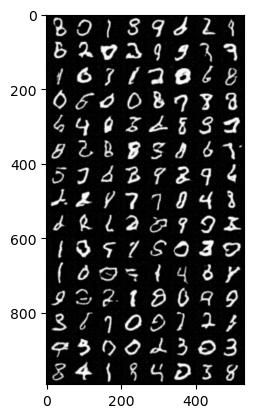

In [26]:
ni = torch.randn(120, 100, 1, 1).to("cuda:0")
xi_fake = net_faker(ni).data.to("cpu")
imshow(xi_fake)

# 3. 단순회귀문제 -- 10점

주어진 자료가 아래와 같다고 하자. 

In [190]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

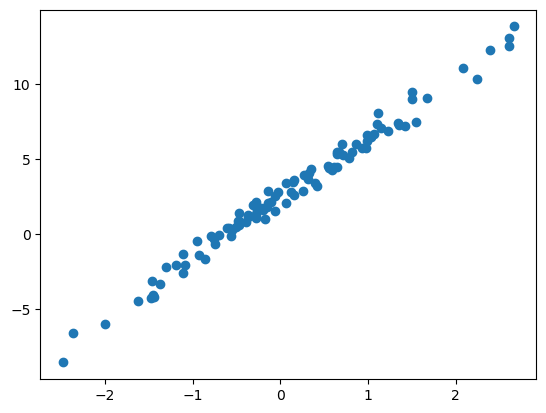

In [191]:
plt.plot(x,y,'o')

`(1)` `torch.nn.Linear`를 이용하여 아래와 같은 최초의 직선을 생성하는 네트워크를 설계하라. -- 1점

$$\hat{y}_i = -5.0 + 10.0 x_i $$

(풀이) 

In [192]:
l = torch.nn.Linear(in_features=1,out_features=1,bias=True)
l.weight.data = l.weight.data*0 + 10 
l.bias.data = l.bias.data*0 - 5 

In [193]:
l(x)[:5], (-5+10*x)[:5] 

(tensor([[-29.8211],
         [-28.6215],
         [-24.9730],
         [-21.2394],
         [-19.7919]], grad_fn=<SliceBackward0>),
 tensor([[-29.8211],
         [-28.6215],
         [-24.9730],
         [-21.2394],
         [-19.7919]]))

`(2)` 아래의 수식에 대응하는 `loss`를 계산하라. 여기에서 $\hat{y}_i$은 (1)의 결과로 얻은 값을 사용하라. -- 1점

$$loss = \frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

(풀이)

In [194]:
loss_fn = torch.nn.MSELoss()
loss_fn(y,l(x))

tensor(85.8769, grad_fn=<MseLossBackward0>)

`(3)` 적당한 matrix ${\bf X}_{n\times 2}$ 와 $\hat{\bf W}_{2\times 1}$ 을 정의하여 아래와 같이 $\hat{y}_i$을 구하라. -- 1점

$$\hat{y}_i = -5.0 + 5.0 x_i $$

(풀이)

In [195]:
What = torch.tensor([[-5.0],[5.0]],requires_grad=True)
X = torch.concat([torch.ones(100,1),x],axis=1)
(X@What)[:5], (-5+5*x)[:5] 

(tensor([[-17.4106],
         [-16.8107],
         [-14.9865],
         [-13.1197],
         [-12.3960]], grad_fn=<SliceBackward0>),
 tensor([[-17.4106],
         [-16.8107],
         [-14.9865],
         [-13.1197],
         [-12.3960]]))

`(4)` 아래의 수식에 대응하는 `loss`를 계산하라. 여기에서 $\hat{y}_i$은 (3)의 결과로 얻은 값을 사용하라. -- 1점

$$loss = \frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

(풀이)

In [196]:
loss_fn(y,X@What)

tensor(55.0216, grad_fn=<MseLossBackward0>)

`(5)` (2)에서 얻은 $\hat{y}_i$ (4)에서 얻은 $\hat{y}_i$ 중 무엇이 더 적절하다고 생각하는가? 이유는 무엇인가? 손실(=loss)에 근거하여 설명하라. -- 2점

(풀이)

(4)에서 얻은 $\hat{y}_i$이 더 적절하다. 이유는 loss값이 더 작기 때문. (55.0216 < 85.8769) 

`(6)` `.backward()` 를 이용하여 (2)와 (4)에 해당하는 미분값을 계산하라. 학습률이 0.01인 경사하강법을 이용하여 (1),(3) 에 대응하는 가중치를 update 하라. -- 4점

(풀이)

In [197]:
loss = loss_fn(y,l(x)) 
loss.backward()
l.weight.data = l.weight.data - 0.01 * l.weight.grad
l.bias.data = l.bias.data - 0.01 * l.bias.grad

In [203]:
print(f"(2)의 update\nweight = {l.weight.data}\nbias = {l.bias.data}")

(2)의 update
weight = tensor([[9.8811]])
bias = tensor([-4.8658])


In [199]:
loss = loss_fn(y,X@What) 
loss.backward()
What = What.data - 0.01 * What.grad

In [204]:
print(f"(4)의 update\n{What.data}")

(4)의 update
tensor([[-4.8535],
        [ 4.9955]])


(또 다른 풀이)

In [209]:
l = torch.nn.Linear(in_features=1,out_features=1,bias=True)
optimizr = torch.optim.SGD(l.parameters(),lr=0.01) 
l.weight.data = l.weight.data*0 + 10 
l.bias.data = l.bias.data*0 - 5 
#--# 
yhat = l(x) # step1 
loss = loss_fn(y,yhat) # step2 
loss.backward() # step 3 
optimizr.step() # step 4 
print(f"(2)의 update\nweight = {l.weight.data}\nbias = {l.bias.data}")

(2)의 update
weight = tensor([[9.8811]])
bias = tensor([-4.8658])


In [208]:
What = torch.tensor([[-5.0],[5.0]],requires_grad=True)
X = torch.concat([torch.ones(100,1),x],axis=1)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([What],lr=0.01) # 이건 안알려준 코드임
#--#
yhat = X@What # step1 
loss = loss_fn(y,yhat) # step2  
loss.backward() # step3 
optimizr.step() # step4 
print(f"(4)의 update\n{What.data}")

(4)의 update
tensor([[-4.8535],
        [ 4.9955]])


# 4. 네트워크 설계 -- 10점

아래는 mnist자료를 분류하는 네트워크의 예시이다. 그림에 대응하는 네트워크를 파이토치로 설계하라. 

![](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)

- 그림에서 n1=6, n2=16, n3=120 으로 설정하고, 드랍아웃비율은 50%로 설정하라. 
- 인풋이미지의 차원은 (28,28,1) 이 아니라 (n,1,28,28) 로 해석하라. 동일한 논리로 Conv1의 통과결과도 (n,n1,24,24) 로 해석하라. 
- valid padding 의 의미는 padding 을 하지 않는다는 의미이다. 

(풀이) 

In [216]:
x = torch.zeros(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [217]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,6,kernel_size=(5,5)),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(6,16,kernel_size=(5,5)),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Flatten(),
    torch.nn.Linear(256,120),
    torch.nn.ReLU(),
    torch.nn.Linear(120,10),
    torch.nn.Dropout(0.5),
    #torch.nn.Softmax()
)

In [224]:
for i,l in enumerate(net):
    print(f"{i}: {net[:i](x).shape} -- {str(l)}")

0: torch.Size([1, 1, 28, 28]) -- Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
1: torch.Size([1, 6, 24, 24]) -- MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2: torch.Size([1, 6, 12, 12]) -- Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
3: torch.Size([1, 16, 8, 8]) -- MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
4: torch.Size([1, 16, 4, 4]) -- Flatten(start_dim=1, end_dim=-1)
5: torch.Size([1, 256]) -- Linear(in_features=256, out_features=120, bias=True)
6: torch.Size([1, 120]) -- ReLU()
7: torch.Size([1, 120]) -- Linear(in_features=120, out_features=10, bias=True)
8: torch.Size([1, 10]) -- Dropout(p=0.5, inplace=False)


# 5. 신경망의 학습 -- 10점

아래를 이용하여 데이터를 불러오라.

In [132]:
x = torch.linspace(-1,1,2000).reshape(2000,1)
u = -1 + 5*x
v = torch.exp(u) / (1+torch.exp(u)) 
y = torch.bernoulli(v)

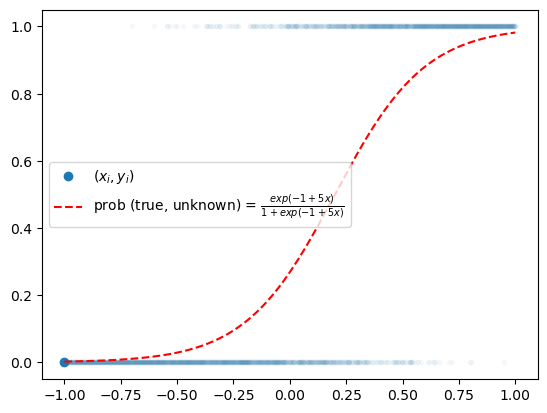

In [133]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

`(1)` `torch.utils.data.TensorDataset`, `torch.utils.data.DataLoader` 를 이용하여 아래의 세부지침을 따르는 적당한 dataloader를 만들라. -- 2점

**세부지침**

1. `batch_size = 128` 로 설정할 것
2. `shuffle = False` 로 설정할 것 

(풀이) 

In [135]:
ds = torch.utils.data.TensorDataset(x,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128,shuffle=False)

`(2)` 주어진 자료를 해석할 수 있는 적절한 `net` 및 손실함수를 설정하고 아래의 세부지침에 맞추어 학습하라. -- 8점

**세부지침**

1. 30 epochs 학습
2. GPU를 이용하여 학습 할 것 
3. 옵티마이저로 `torch.optim.Adam`을 사용하고 학습률은 0.05로 설정할 것 

(풀이) 

In [186]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.05)

In [187]:
for epoc in range(30):
    for xi,yi in dl:
        ## step0: 싹다 쿠다로..
        xi = xi.to("cuda:0")
        yi = yi.to("cuda:0")
        ## step1 
        yi_hat = net(xi)
        ## step2 
        loss = loss_fn(yi_hat, yi) 
        ## step3 
        loss.backward()
        ## step4 
        optimizr.step()
        optimizr.zero_grad()

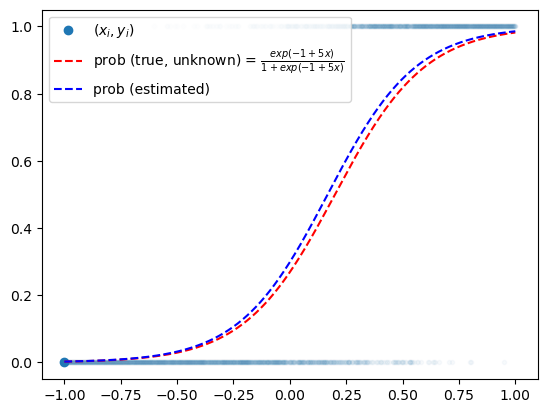

In [188]:
net.to("cpu")
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,v,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,net(x).data,'--b',label=r"prob (estimated)")
plt.legend()